In [ ]:
!nvidia-smi

Fri Oct  4 14:57:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0              30W /  70W |   6495MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-9xpft_h8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-9xpft_h8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [ ]:
# Change to the home directory (optional in Colab, as it starts in /content)
import os
os.chdir('/content')

# Create a weights directory
!mkdir weights

# Change to the weights directory
os.chdir('weights')

# Download the weights file
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

mkdir: cannot create directory ‘weights’: File exists


In [ ]:
# Define the checkpoint path
CHECKPOINT_PATH = os.path.join('/content', 'weights', 'sam_vit_h_4b8939.pth')

# Check if the checkpoint file exists
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import os

# Configuration
CHECKPOINT_PATH = '/content/weights/sam_vit_h_4b8939.pth'  # Path to your SAM model
MODEL_TYPE = 'vit_h'  # Specify your SAM model type
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if available

# Load SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Function to display the image
def display_image(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.imshow(image)
        plt.axis('off')  # Hide axis
        plt.show()
    else:
        print(f"Error: Image at {image_path} could not be loaded.")

# Function to detect an object, segment it using SAM, and display it in red
def detect_and_segment(image_path, target_object):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Image at {image_path} could not be loaded.")
        return

    # Detect objects using YOLOv5
    results = model(img)
    labels, cords = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
    object_detected = False

    # Iterate through detected objects to find the target object
    for label, cord in zip(labels, cords):
        if model.names[int(label)] == target_object:
            object_detected = True
            x1, y1, x2, y2, conf = cord
            print(f"{target_object.capitalize()} detected with confidence {conf:.2f} at location: ({x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f})")

            # Extract ROI
            h, w = img.shape[:2]
            x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)
            roi = img[y1:y2, x1:x2]
            print("Region of Interest (ROI) extracted.")

            # Segment the ROI using SAM
            image_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            sam_result = mask_generator.generate(image_rgb)
            if not sam_result:
                print("No segments found in the ROI.")
                return

            # Display the number of segments found
            print(f"Found {len(sam_result)} segments.")

            # Find and apply the largest mask
            largest_mask = None
            max_area = 0
            for mask in sam_result:
                segmentation = mask['segmentation']
                area = np.sum(segmentation)
                if area > max_area:
                    max_area = area
                    largest_mask = segmentation.astype(np.uint8) * 255

            print(f"Applying the largest mask with area {max_area}.")

            # Create a red highlight for the segmented object
            red_highlight = np.zeros_like(roi)
            red_highlight[:, :, 2] = 255  # Set Red channel to 255

            # Blend the original ROI with the red highlight using the mask
            highlighted_roi = cv2.bitwise_and(red_highlight, red_highlight, mask=largest_mask)
            highlighted_roi = cv2.addWeighted(highlighted_roi, 0.5, roi, 0.5, 0)

            # Replace the ROI in the original image with the highlighted version
            img[y1:y2, x1:x2] = highlighted_roi

            # Save and display the final image with red-highlighted object
            name = f'/content/highlighted_{target_object}.jpg'
            cv2.imwrite(name, img)
            print(f"Image with segmented object saved as '{name}'.")

            # Check if the file exists before displaying
            if os.path.exists(name):
                display_image(name)  # Call function to display the image
            else:
                print(f"Error: Image '{name}' was not saved correctly.")
            break

    if not object_detected:
        print(f"No {target_object} detected.")

# Example usage
image_path1 = '/content/chair.jpg'  # Replace with your image path
target_object1 = 'chair'  # The object you want to segment
detect_and_segment(image_path1, target_object1)

image_path2 = '/content/flower_vase.jpg'  # Replace with your image path
target_object2 = 'vase'  # The object you want to segment
detect_and_segment(image_path2, target_object2)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-4 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Chair detected with confidence 0.83 at location: (0.30, 0.37, 0.67, 0.90)
Region of Interest (ROI) extracted.
Found 75 segments.
Applying the largest mask with area 9803.
Image with segmented object saved as '/content/highlighted_chair.jpg'.
Vase detected with confidence 0.91 at location: (0.26, 0.47, 0.73, 0.87)
Region of Interest (ROI) extracted.


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Found 17 segments.
Applying the largest mask with area 9701.
Image with segmented object saved as '/content/highlighted_vase.jpg'.


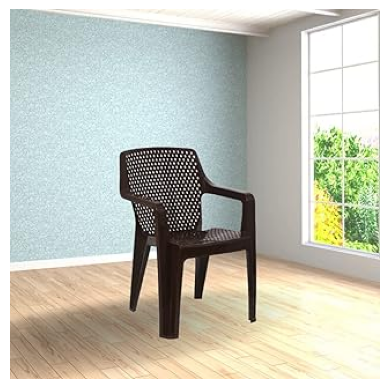

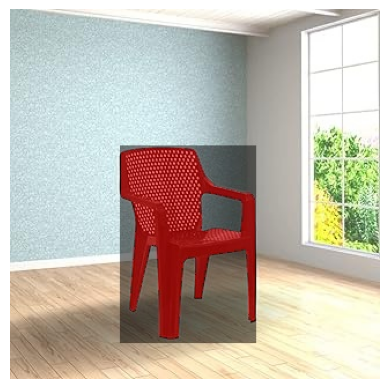

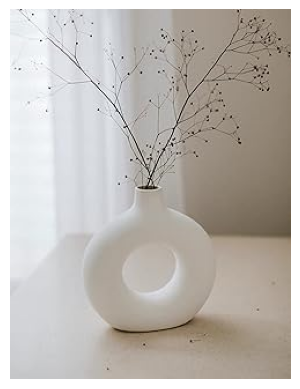

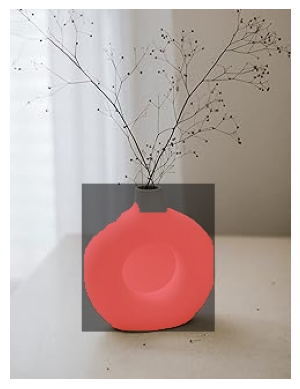

In [1]:
import cv2
import matplotlib.pyplot as plt
def display_image(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.imshow(image)
        plt.axis('off')  # Hide axis
        plt.show()
    else:
        print(f"Error: Image at {image_path} could not be loaded.")
display_image("/content/chair.jpg")
display_image("/content/highlighted_chair.jpg")
display_image("/content/flower_vase.jpg")
display_image("/content/highlighted_vase.jpg")